Clustering techniques

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, date, time, timezone
from natsort import index_natsorted

# Functions

In [3]:
def parseFilenameToDate(Filename):
  new_str = Filename.replace(".","/")
  dt = datetime.strptime(new_str, "%Y/%m/%d/%H/%M/%S")
  return dt

In [4]:
def getRealRUL(index, data):
  # Returns the time from the given point to the breakdown of the machine (last index)
  t1 = data.loc[index, "Filename"]
  t2 = data["Filename"].iloc[-1]
  diff = t2-t1
  return diff


In [5]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Load Data
Choose desired filename in cell below

In [6]:
datafile = "/content/drive/MyDrive/nimbus-test3-CH3-fixed.csv"

## Renaming

In [7]:
data = pd.read_csv(datafile, index_col=0)
data

,tsnePCA-2d-one,tsnePCA-2d-two,RMS,Filename
813,31.244444,69.245735,0.970453,2004.04.17.00.02.55
825,34.486343,65.962940,1.188294,2004.04.16.23.52.55
826,30.908306,68.715034,1.697124,2004.04.16.23.42.55
840,32.211372,69.867260,1.534403,2004.04.17.01.12.55
841,27.794624,73.280060,1.199807,2004.04.17.02.42.55
...,...,...,...,...
995,47.969376,59.155186,98.199024,2004.04.18.02.22.55
996,36.847652,67.585160,2.334934,2004.04.18.00.12.55
997,46.599865,59.537940,5.665934,2004.04.18.00.22.55
998,47.822420,59.045563,89.106880,2004.04.18.02.32.55


For convenience, renaming the columns

In [8]:
data = data.rename(columns={"tsnePCA-2d-one":"tsne-1", "tsnePCA-2d-two":"tsne-2"})
data

,tsne-1,tsne-2,RMS,Filename
813,31.244444,69.245735,0.970453,2004.04.17.00.02.55
825,34.486343,65.962940,1.188294,2004.04.16.23.52.55
826,30.908306,68.715034,1.697124,2004.04.16.23.42.55
840,32.211372,69.867260,1.534403,2004.04.17.01.12.55
841,27.794624,73.280060,1.199807,2004.04.17.02.42.55
...,...,...,...,...
995,47.969376,59.155186,98.199024,2004.04.18.02.22.55
996,36.847652,67.585160,2.334934,2004.04.18.00.12.55
997,46.599865,59.537940,5.665934,2004.04.18.00.22.55
998,47.822420,59.045563,89.106880,2004.04.18.02.32.55


## Re-Order data by time

In [9]:
reordered_data = data.sort_values(
   by="Filename",
   key=lambda x: np.argsort(index_natsorted(data["Filename"]))
)

In [10]:
reordered_data

,tsne-1,tsne-2,RMS,Filename
826,30.908306,68.715034,1.697124,2004.04.16.23.42.55
825,34.486343,65.962940,1.188294,2004.04.16.23.52.55
813,31.244444,69.245735,0.970453,2004.04.17.00.02.55
860,31.777418,68.182550,1.552761,2004.04.17.00.12.55
858,33.993640,66.935420,1.749911,2004.04.17.00.22.55
...,...,...,...,...
991,46.104366,60.927776,6.183291,2004.04.18.01.52.55
993,47.453750,59.602410,24.815157,2004.04.18.02.02.55
983,38.144264,64.904370,9.229391,2004.04.18.02.12.55
995,47.969376,59.155186,98.199024,2004.04.18.02.22.55


In [11]:
reordered_data.loc[:,"Filename"] = reordered_data.loc[:,"Filename"].apply(parseFilenameToDate)

<ipython-input-11-256ec5d2b8df>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  reordered_data.loc[:,"Filename"] = reordered_data.loc[:,"Filename"].apply(parseFilenameToDate)


In [12]:
getRealRUL(995,reordered_data)

Timedelta('0 days 00:10:00')

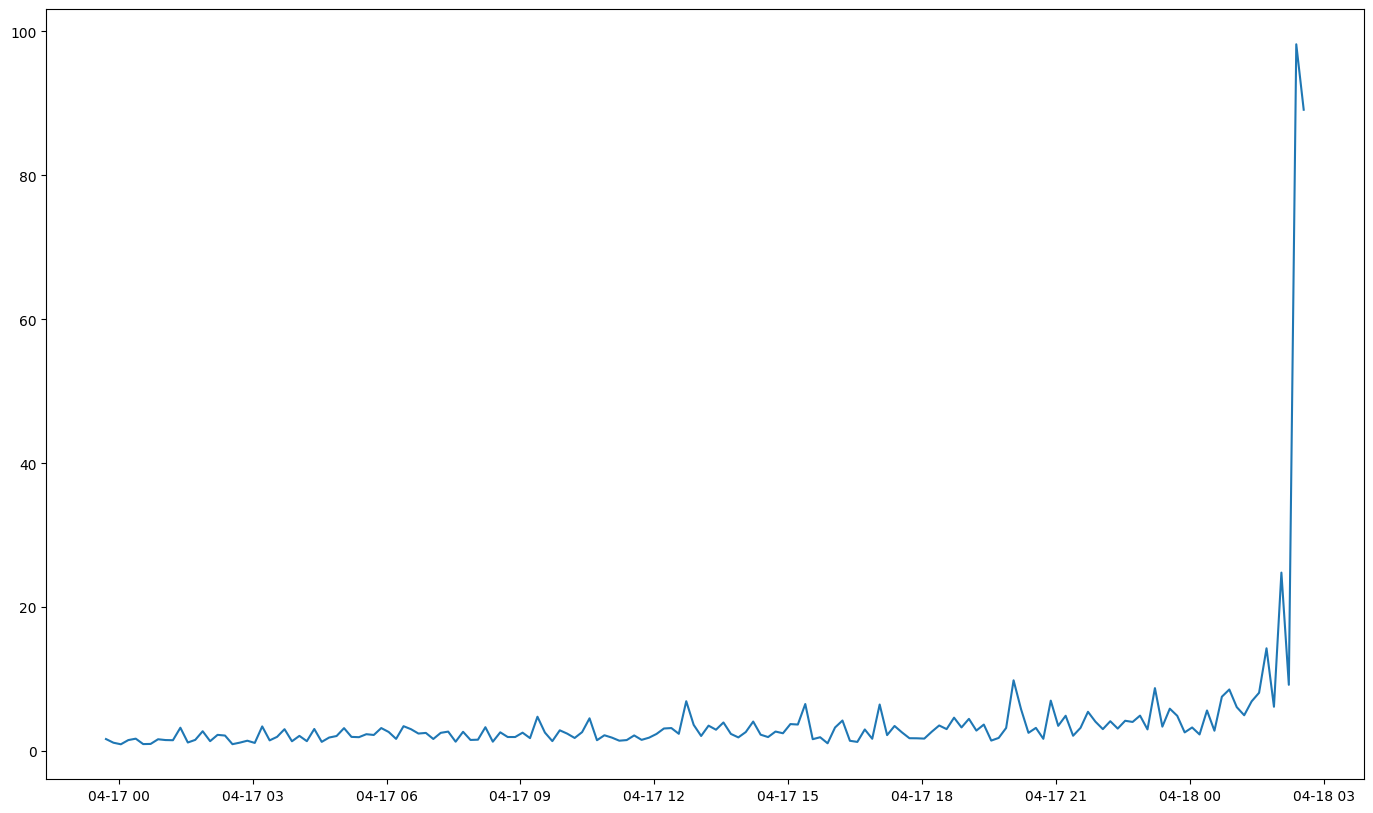

In [13]:
plt.figure(figsize=(17,10))
plt.plot(reordered_data.Filename, reordered_data["RMS"].values, label = "RMS")
plt.show()

In [14]:
data = reordered_data

## Plot with colours

In [15]:
def new_fromRMStoMedium(value):
  if (value < 1.80):
    return "Good"
  if (value < 4.50):
    return "Satisfactory"
  if (value < 11.20):
    return "Unsatisfactory (alert)"
  else:
    return "Unacceptable (danger)"

In [16]:
def new_tokenizeRMS(column):
  """
  Transforms a column of a df into a tokenized column
  according to ISO-10816, RMS mm/s
  """
  # For Medium Machine Class II
  result = column.apply(new_fromRMStoMedium)

  return result

In [17]:
tokenized = new_tokenizeRMS(data["RMS"])

In [18]:
seaborn_palette = sns.color_palette()
custom_palette = {
    "Good": seaborn_palette[0],
    "Satisfactory" : seaborn_palette[2],
    "Unsatisfactory (alert)" : seaborn_palette[1],
    "Unacceptable (danger)" : seaborn_palette[3]
}

<Axes: xlabel='tsne-1', ylabel='tsne-2'>

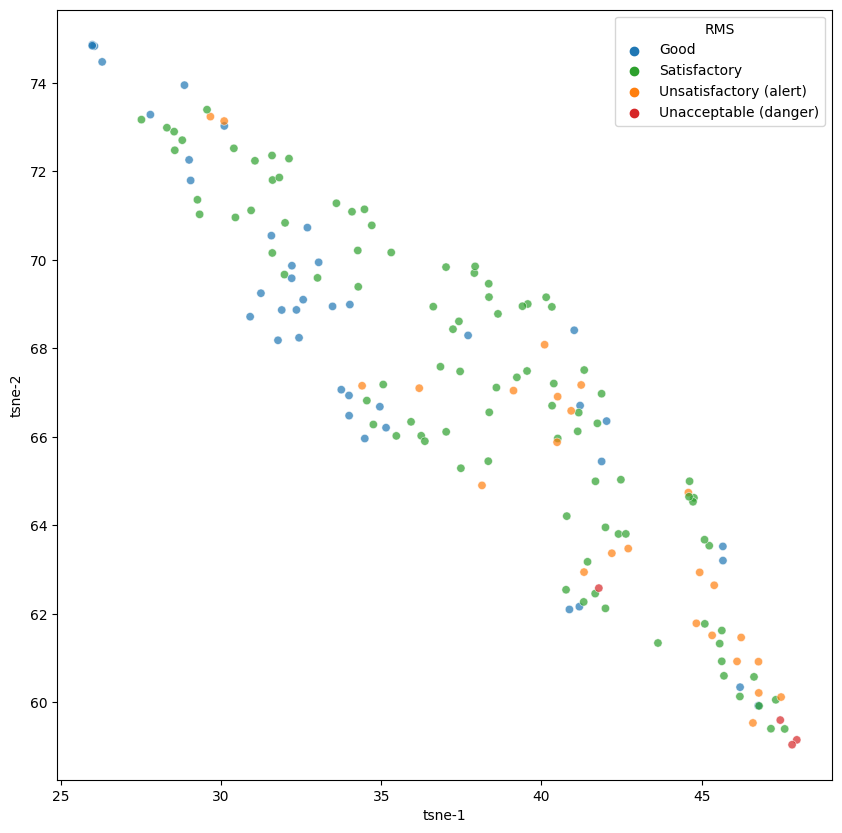

In [19]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue=tokenized,
    palette=custom_palette,
    data=data,
    legend="full",
    alpha=0.7
)

<Axes: xlabel='tsne-1', ylabel='tsne-2'>

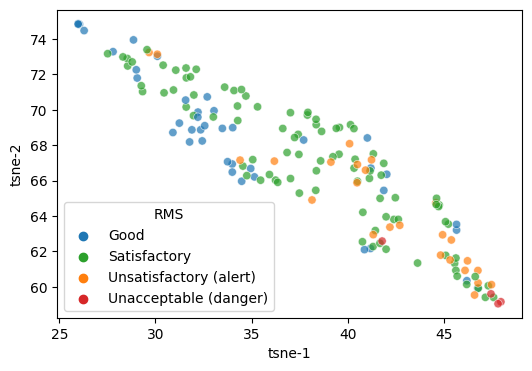

In [26]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue=tokenized,
    palette=custom_palette,
    data=data,
    legend="full",
    alpha=0.7
)

## Split to only the necessary data for models

In [20]:
tsne_data = data.iloc[:, :2]
tsne_data

,tsne-1,tsne-2
826,30.908306,68.715034
825,34.486343,65.962940
813,31.244444,69.245735
860,31.777418,68.182550
858,33.993640,66.935420
...,...,...
991,46.104366,60.927776
993,47.453750,59.602410
983,38.144264,64.904370
995,47.969376,59.155186


<Axes: xlabel='tsne-1', ylabel='tsne-2'>

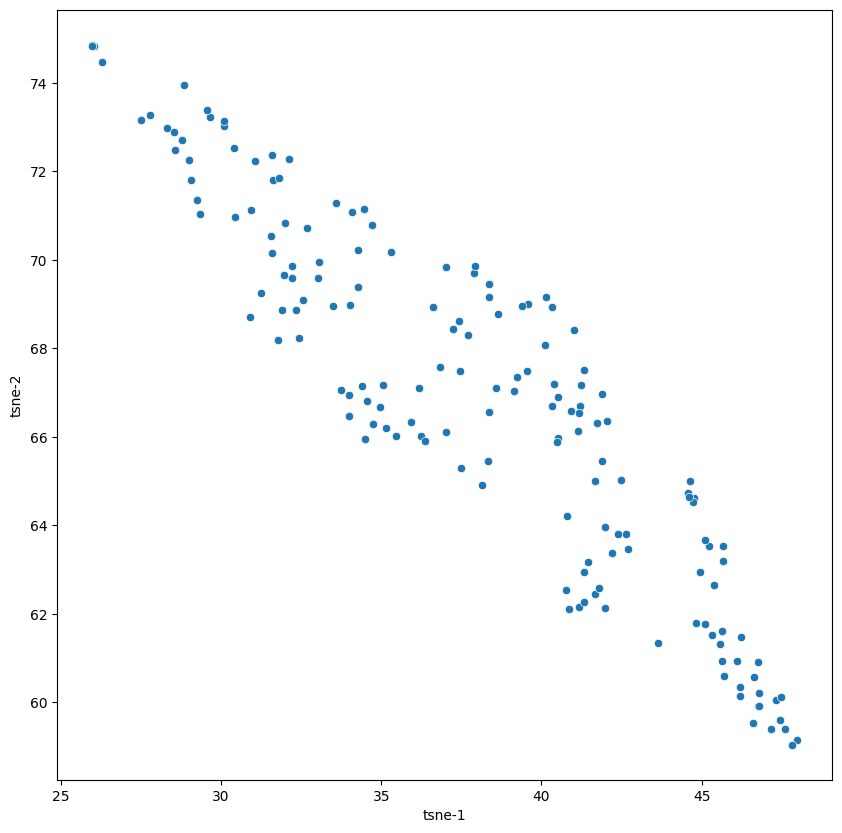

In [21]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    data=tsne_data
)

# Clustering
For the data that is more prone to fail, look for groups that may give more info about the state of the machine

## Number of clusters known
K-Means

### Applying the algorithm

In [ ]:
n_clusters = 2
seed = 0

In [ ]:
model = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto")

In [ ]:
kmeans = model.fit_predict(tsne_data)
kmeans

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
c1 = model.cluster_centers_[0]
c2 = model.cluster_centers_[1]

<ipython-input-59-5e60b7af5bcf>:4: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='tsne-1', ylabel='tsne-2'>

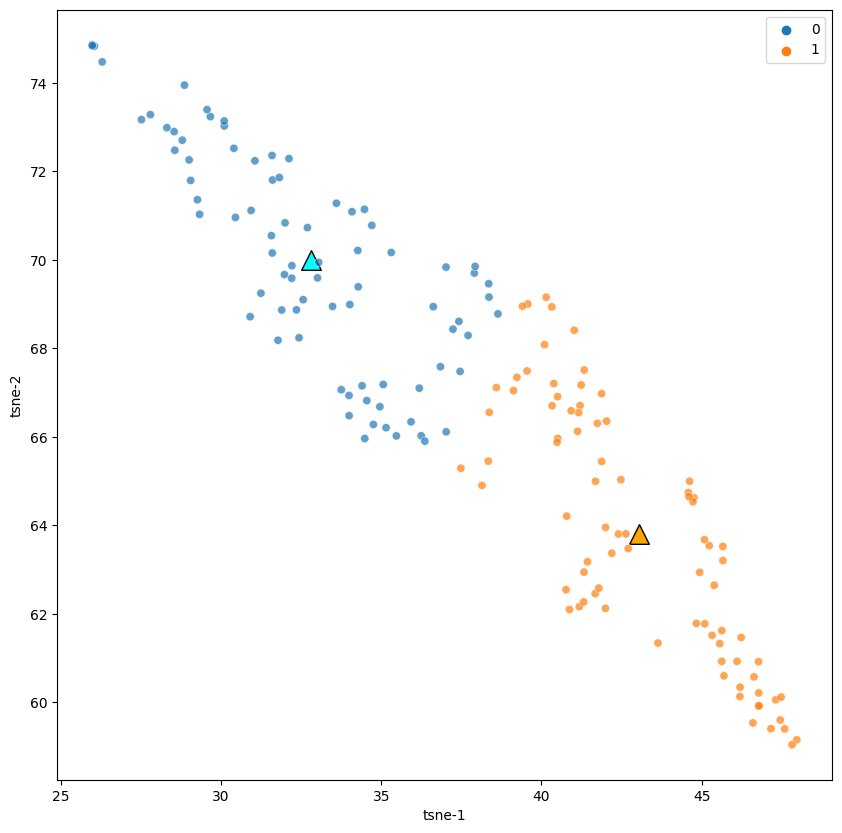

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(x=c1[0], y=c1[1], color="cyan", edgecolors="black", marker="^", s=200)
plt.scatter(x=c2[0], y=c2[1], color="orange", edgecolors="black", marker="^", s=200)
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    data=tsne_data,
    hue=kmeans,
    palette=sns.color_palette(),
    legend="full",
    alpha=0.7
)

### Analyse results with RUL


Thresholds:
* Good: <1.80
* Satisfactory: <4.50
* Unsatisfactory (Alert): <11.20
* Unnaceptable (Danger): >=11.20

In [ ]:
alert_threshold = 4.5

In [ ]:
kmeans_data = data
kmeans_data["Class"] = model.labels_
kmeans_data

,tsne-1,tsne-2,RMS,Filename,Class
826,30.908306,68.715034,1.697124,2004-04-16 23:42:55,0
825,34.486343,65.962940,1.188294,2004-04-16 23:52:55,0
813,31.244444,69.245735,0.970453,2004-04-17 00:02:55,0
860,31.777418,68.182550,1.552761,2004-04-17 00:12:55,0
858,33.993640,66.935420,1.749911,2004-04-17 00:22:55,0
...,...,...,...,...,...
991,46.104366,60.927776,6.183291,2004-04-18 01:52:55,1
993,47.453750,59.602410,24.815157,2004-04-18 02:02:55,1
983,38.144264,64.904370,9.229391,2004-04-18 02:12:55,1
995,47.969376,59.155186,98.199024,2004-04-18 02:22:55,1


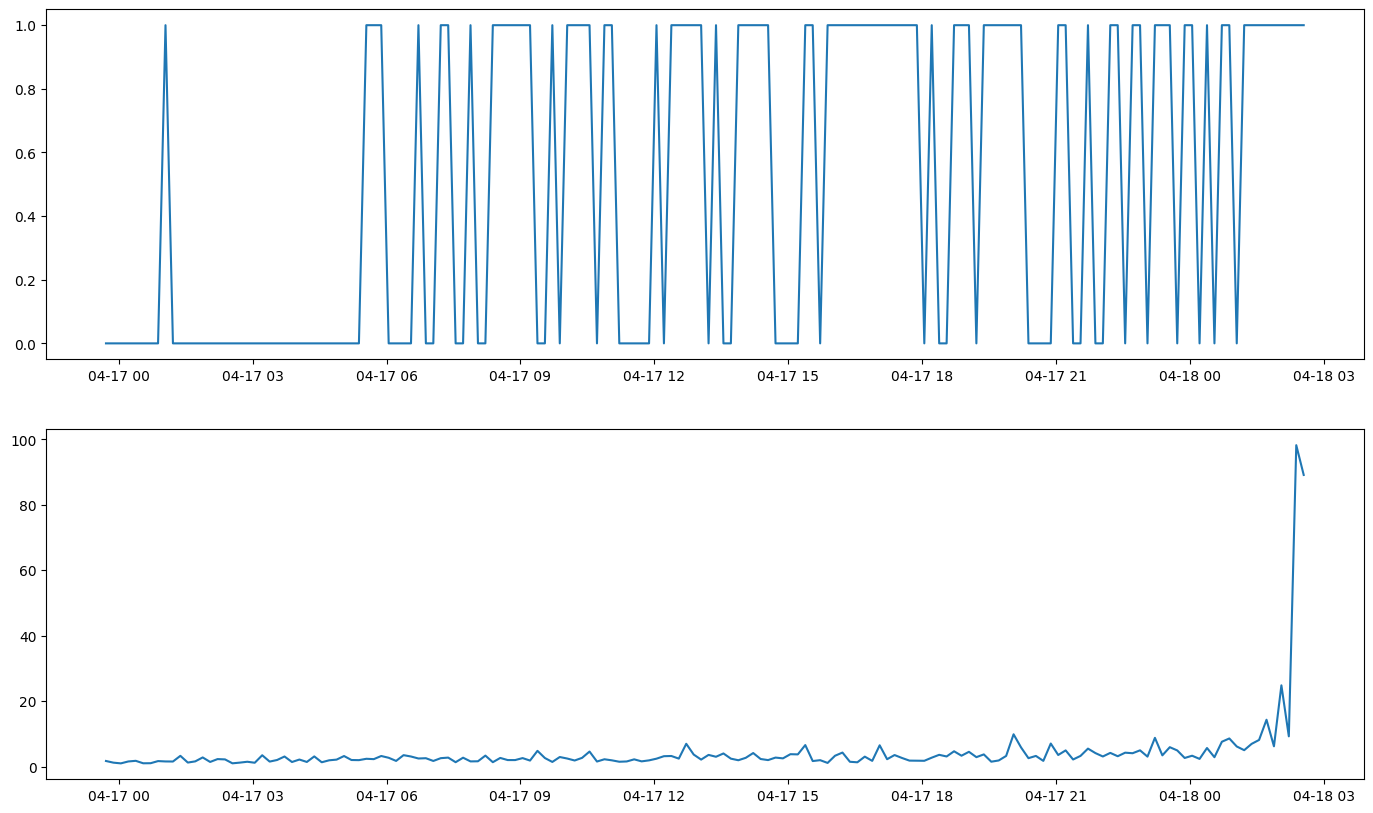

In [ ]:
plt.figure(figsize=(17,10))
plt.subplot(211)
plt.plot(kmeans_data["Filename"], kmeans_data["Class"])
plt.subplot(212)
plt.plot(kmeans_data["Filename"], kmeans_data["RMS"])
plt.show()

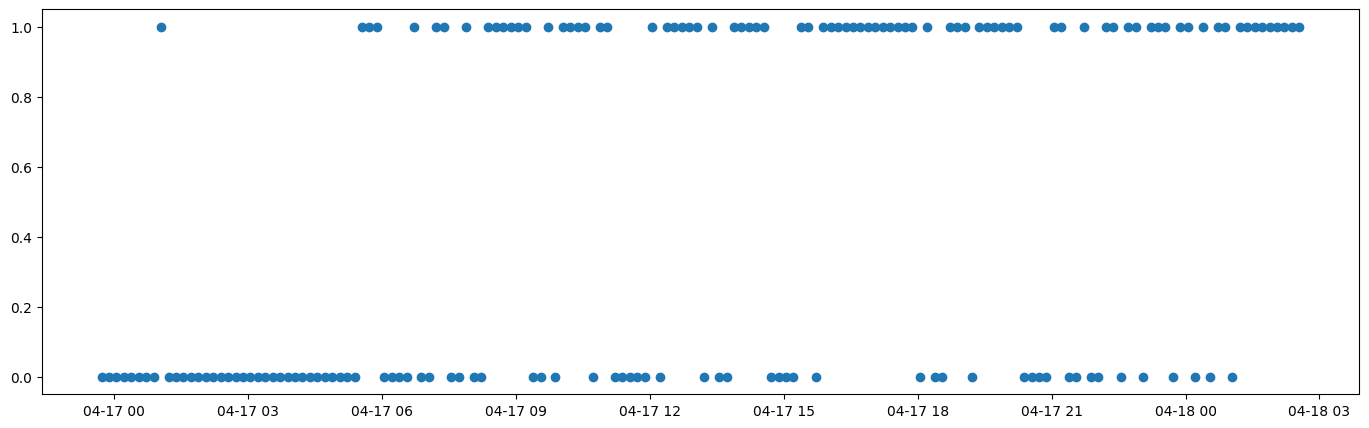

In [ ]:
plt.figure(figsize=(17,5))
plt.scatter(kmeans_data["Filename"], kmeans_data["Class"])

In [ ]:
kmeans_data["Alert"] = kmeans_data["RMS"] >= alert_threshold
kmeans_data

,tsne-1,tsne-2,RMS,Filename,Class,Alert
826,30.908306,68.715034,1.697124,2004-04-16 23:42:55,0,False
825,34.486343,65.962940,1.188294,2004-04-16 23:52:55,0,False
813,31.244444,69.245735,0.970453,2004-04-17 00:02:55,0,False
860,31.777418,68.182550,1.552761,2004-04-17 00:12:55,0,False
858,33.993640,66.935420,1.749911,2004-04-17 00:22:55,0,False
...,...,...,...,...,...,...
991,46.104366,60.927776,6.183291,2004-04-18 01:52:55,1,True
993,47.453750,59.602410,24.815157,2004-04-18 02:02:55,1,True
983,38.144264,64.904370,9.229391,2004-04-18 02:12:55,1,True
995,47.969376,59.155186,98.199024,2004-04-18 02:22:55,1,True


<Axes: xlabel='Filename', ylabel='Class'>

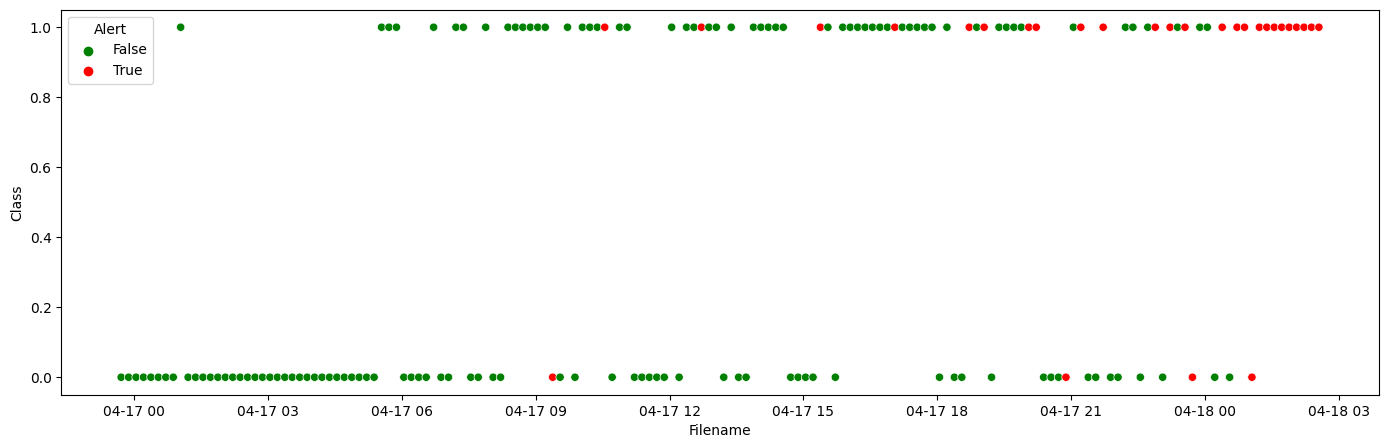

In [ ]:
plt.figure(figsize=(17,5))
sns.scatterplot(x=kmeans_data["Filename"], y=kmeans_data["Class"], hue=kmeans_data["Alert"], palette=["green","red"])

Explicación puntos intercalados

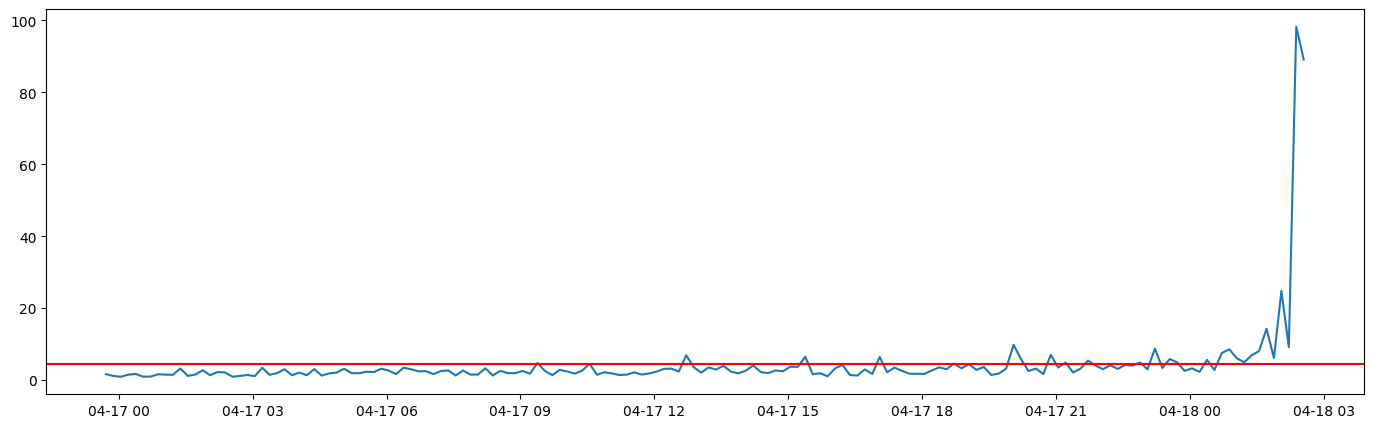

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(kmeans_data["Filename"], kmeans_data["RMS"])
plt.axhline(y=alert_threshold, color='r', linestyle='-')
plt.show()

### Same for more clusters

In [ ]:
n_clusters = 3
seed = 0

In [ ]:
model = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto")

In [ ]:
kmeans = model.fit_predict(tsne_data)
kmeans

array([0, 2, 0, 0, 2, 2, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 0, 2, 2, 1, 0,
       0, 1, 1, 0, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1,
       0, 2, 1, 0, 0, 0, 2, 2, 2, 0, 1, 1, 1, 1, 1, 0, 2, 0, 2, 1, 2, 2,
       2, 2, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1,
       2, 1, 2, 2, 1, 2, 2, 0, 2, 1, 1, 2, 2, 2, 0, 0, 0, 0, 2, 1, 0, 2,
       2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 2, 1, 1], dtype=int32)

In [ ]:
cc = model.cluster_centers_

<ipython-input-71-9eef67d06d3d>:5: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='tsne-1', ylabel='tsne-2'>

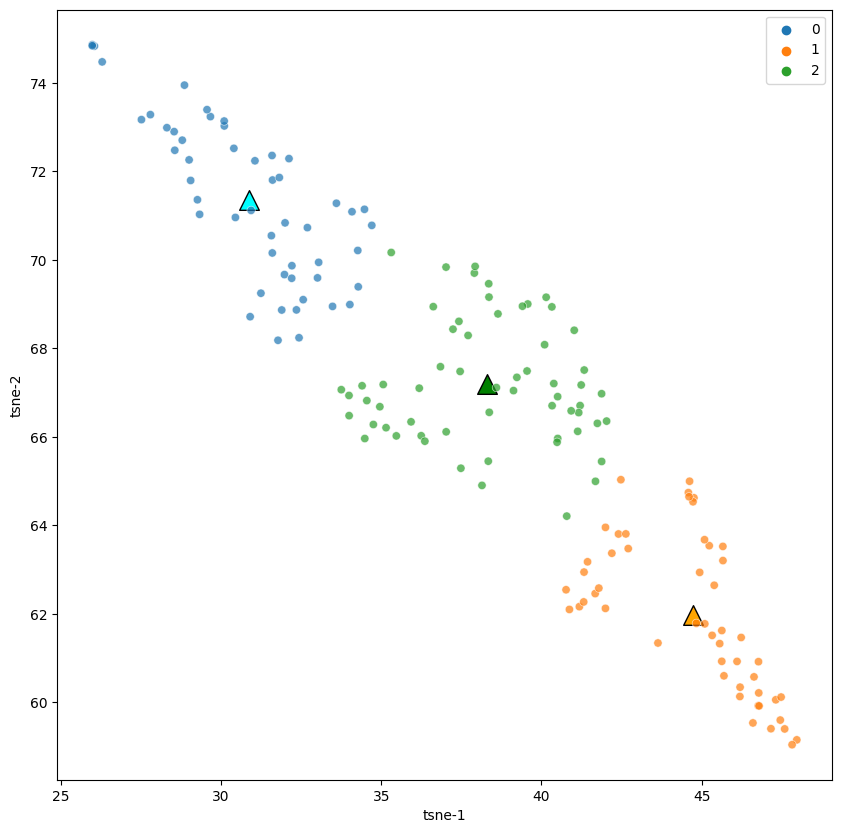

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(x=cc[0][0], y=cc[0][1], color="cyan", edgecolors="black", marker="^", s=200)
plt.scatter(x=cc[1][0], y=cc[1][1], color="orange", edgecolors="black", marker="^", s=200)
plt.scatter(x=cc[2][0], y=cc[2][1], color="green", edgecolors="black", marker="^", s=200)
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    data=tsne_data,
    hue=kmeans,
    palette=sns.color_palette(),
    legend="full",
    alpha=0.7
)

In [ ]:
kmeans_data = data
kmeans_data["Class"] = model.labels_
kmeans_data["Alert"] = kmeans_data["RMS"] >= alert_threshold

<Axes: xlabel='Filename', ylabel='Class'>

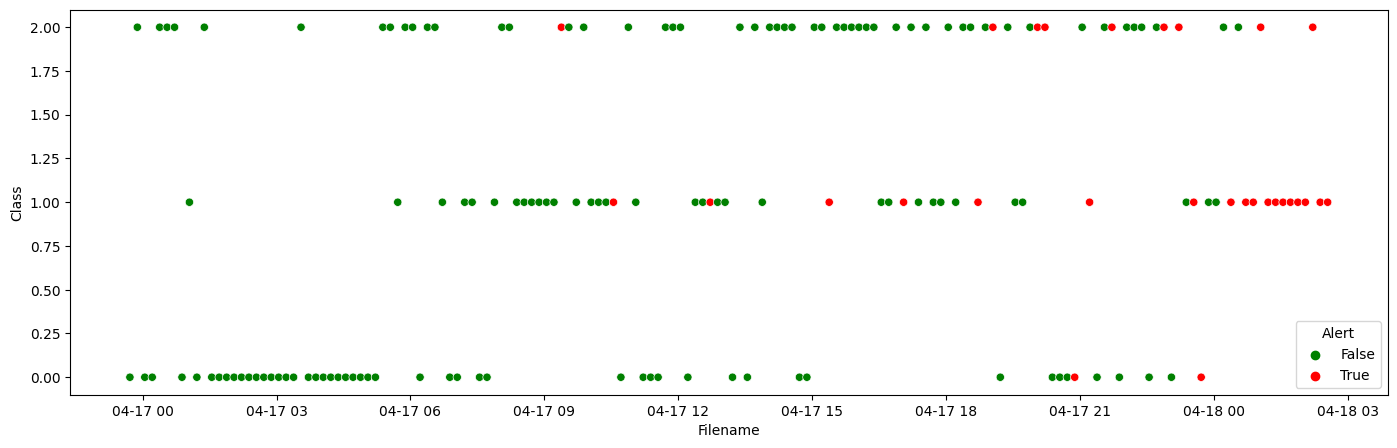

In [ ]:
plt.figure(figsize=(17,5))
sns.scatterplot(x=kmeans_data["Filename"], y=kmeans_data["Class"], hue=kmeans_data["Alert"], palette=["green","red"])

## Unknown number of Clusters
Hierarchical Clustering: [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

Depending on the linkage, different results can be obtained:
* ‘ward’ minimizes the variance of the clusters being merged.

* ‘average’ uses the average of the distances of each observation of the two sets.

* ‘complete’ or ‘maximum’ linkage uses the maximum distances between all observations of the two sets.

* ‘single’ uses the minimum of the distances between all observations of the two sets.

Compute_distances for dendogram representations

In [ ]:
linkage = "ward"

### Dendogram
[Plot dendogram](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

No more than p levels of the dendrogram tree are displayed. A “level” includes all nodes with p merges from the final merge.

In [ ]:
n_clusters = None
distance_threshold = 0
compute_distances = True

In [ ]:
model = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters,
                                distance_threshold=distance_threshold, compute_distances=compute_distances)

clustering = model.fit_predict(tsne_data)

clustering

array([ 82, 110, 141, 161, 133, 139, 114, 104, 150, 126,  94, 103, 143,
        99, 159, 121, 140,  80, 128, 125, 108,  62,  93, 115, 119, 111,
       101, 160, 134,  69, 142, 116,  89, 144, 127, 102, 137,  90, 151,
        85, 138, 123, 129, 153,  57, 120,  46, 117, 112, 107, 100, 152,
        71,  87, 145,  70, 130,  79,  81,  88,  39,  40,  63, 109, 124,
       118, 155, 131,  75, 147, 154,  59,  86,  53, 135,  84, 148,  61,
        66,  34,  43, 122,  92, 136,  60,  68,  95,  30,  58, 105, 113,
        96,  64,  76,  97, 106, 157,  37,  91, 149, 132,  29, 158,  14,
       156,  74,  52,  65, 146,  28,  50,  55,  42,  19,  56,  47,  83,
        27,  98,  49,  45,  51,  41,  31,  20,  48,  77,  72,  32,  73,
        13,  78,  44,  25,  15,  54,  36,  21,  38,  22,   6,  18,  67,
        35,  24,  33,  16,  10,   9,   7,  23,  17,  26,  12,   8,  11,
         5,   2,   3,   4,   1,   0])

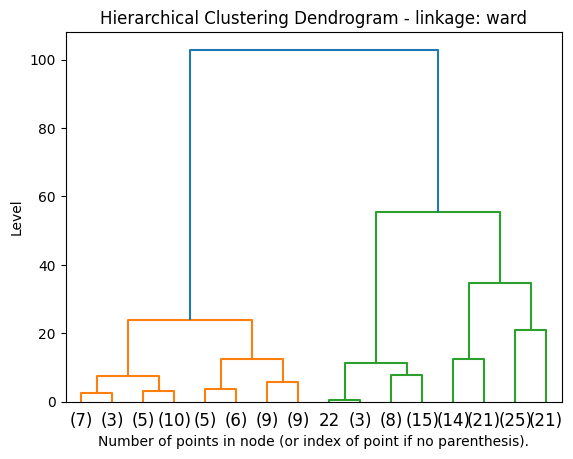

In [ ]:
plt.title(f"Hierarchical Clustering Dendrogram - linkage: {linkage}")
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Level")
plt.show()

### 5 clusters, different linkages

In [ ]:
n_clusters = 5
distance_threshold = None
compute_distances = True

In [ ]:
model = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters,
                                distance_threshold=distance_threshold, compute_distances=compute_distances)

clustering = model.fit_predict(tsne_data)

clustering

array([0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 1, 3, 3, 1, 0, 2, 1, 1, 4, 2,
       0, 4, 3, 0, 0, 3, 0, 0, 4, 3, 4, 4, 3, 4, 0, 0, 4, 0, 4, 4, 4, 4,
       0, 3, 3, 0, 0, 2, 0, 0, 0, 0, 4, 4, 4, 3, 3, 0, 0, 2, 0, 3, 1, 1,
       1, 1, 0, 2, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3,
       1, 3, 0, 1, 4, 1, 1, 0, 1, 3, 3, 1, 1, 1, 0, 2, 2, 2, 1, 3, 2, 1,
       1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 4, 4, 2, 3, 4, 0, 4, 0, 4, 3, 0, 3,
       3, 4, 3, 4, 4, 0, 4, 4])

<ipython-input-98-65eb2b0fc0e0>:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='tsne-1', ylabel='tsne-2'>

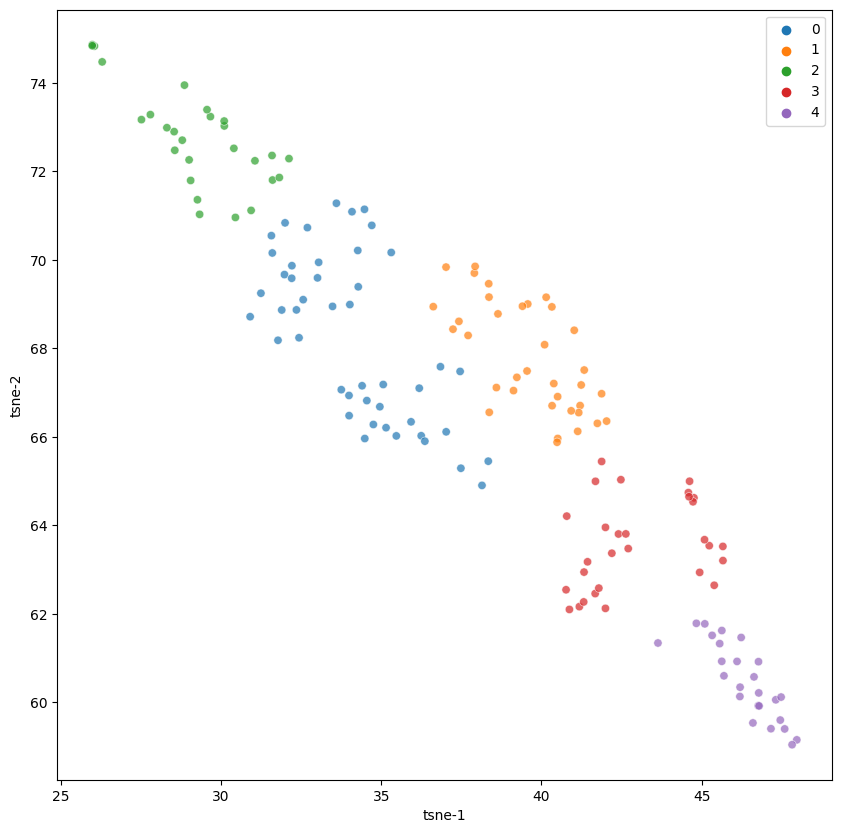

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    data=tsne_data,
    hue=clustering,
    palette=sns.color_palette(),
    legend="full",
    alpha=0.7
)

In [ ]:
cluster_data = data
cluster_data["Class"] = model.labels_
cluster_data["Alert"] = cluster_data["RMS"] >= alert_threshold
cluster_data

,tsne-1,tsne-2,RMS,Filename,Class,Alert
826,30.908306,68.715034,1.697124,2004-04-16 23:42:55,0,False
825,34.486343,65.962940,1.188294,2004-04-16 23:52:55,0,False
813,31.244444,69.245735,0.970453,2004-04-17 00:02:55,0,False
860,31.777418,68.182550,1.552761,2004-04-17 00:12:55,0,False
858,33.993640,66.935420,1.749911,2004-04-17 00:22:55,0,False
...,...,...,...,...,...,...
991,46.104366,60.927776,6.183291,2004-04-18 01:52:55,4,True
993,47.453750,59.602410,24.815157,2004-04-18 02:02:55,4,True
983,38.144264,64.904370,9.229391,2004-04-18 02:12:55,0,True
995,47.969376,59.155186,98.199024,2004-04-18 02:22:55,4,True


<Axes: xlabel='Filename', ylabel='Class'>

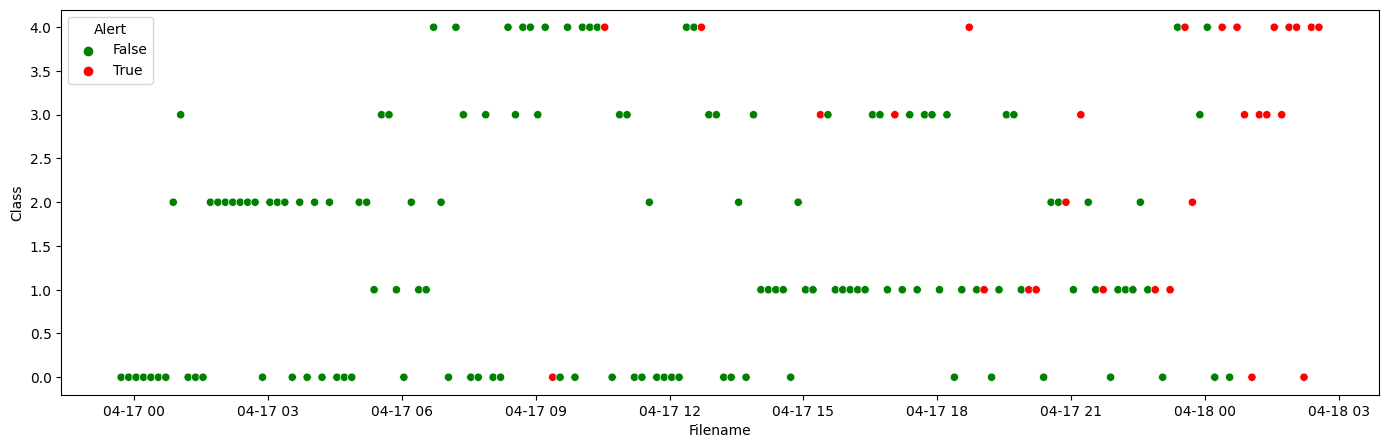

In [ ]:
plt.figure(figsize=(17,5))
sns.scatterplot(x=cluster_data["Filename"], y=cluster_data["Class"], hue=cluster_data["Alert"], palette=["green","red"])
